In [1]:
import pandas as pd
from datetime import timedelta
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
country = 'UK'
month = 'Jun23'
world = False

In [3]:
# For World RFM:
if world == True:
    es = pd.read_excel(f"./{month}/ES/RFM_ES_{month}.xlsx", engine='openpyxl')
    fr = pd.read_excel(f"./{month}/FR/RFM_FR_{month}.xlsx", engine='openpyxl')
    ctk = pd.read_excel(f"./{month}/UK/RFM_UK_{month}.xlsx", engine='openpyxl')
    df = pd.concat([es, fr, ctk])
    df.to_excel(f"./{month}/World/RFM_World_{month}.xlsx", index=False)
elif world == False:
    df = pd.read_excel(f"./{month}/{country}/RFM_{country}_{month}.xlsx", engine='openpyxl')

In [4]:
df.head(3)

,Customer Name,Monetary value,Frequency,Recency
0,1066 POOLS LTD,1107.05,6,191
1,A D SWIMMING POOLS LTD,7780.39,12,36
2,A A POOLS,-170.54,1,277


In [5]:
df2 = df[["Customer Name", "Monetary value", "Frequency", "Recency"]].copy()
df2.columns = ["customer", "monetary", "frequency", "recency"]

In [6]:
df2.head(3)

,customer,monetary,frequency,recency
0,1066 POOLS LTD,1107.05,6,191
1,A D SWIMMING POOLS LTD,7780.39,12,36
2,A A POOLS,-170.54,1,277


In [7]:
rfm=df2[['recency','frequency','monetary']]
rfm.index = df2["customer"]
rfm.head(3)

,recency,frequency,monetary
customer,,,
1066 POOLS LTD,191,6,1107.05
A D SWIMMING POOLS LTD,36,12,7780.39
A A POOLS,277,1,-170.54


In [8]:
cols = ['recency', 'frequency', 'monetary']
rfm[cols] = rfm[cols].apply(pd.to_numeric, errors='coerce')

/opt/anaconda3/envs/pythonlast/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# RFM Scoring

In [9]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['score']= rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)
rfm['score'] = pd.to_numeric(rfm['score'])

In [10]:
pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1], retbins=True)

(customer
 1066 POOLS LTD                     2
 A  D SWIMMING POOLS LTD            4
 A A POOLS                          1
 A2Z POOLS                          1
 AG BUDGET SWIMMING POOLS           5
                                   ..
 WENSUM POOLS LTD                   5
 WEST COUNTRY LEISURE POOL DEVON    3
 WOKINGHAM POOLS AND SPAS LTD       3
 XL POOLS LTD                       2
 YPDT LEISURE LIMITED               2
 Name: recency, Length: 256, dtype: category
 Categories (5, int64): [5 < 4 < 3 < 2 < 1],
 array([  1.,   6.,  65., 162., 202., 335.]))

In [11]:
pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5], retbins=True)[1]

array([  1.,  52., 103., 154., 205., 256.])

In [12]:
pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5], retbins=True)[1]

array([ -1845.25,    246.19,   1109.69,   4403.53,   8426.97, 132885.65])

In [13]:
segment_dictionary = {"Champion TOP": [555, 545, 554],
                      "Growing Champion": [544, 454, 455, 445],
                      "Loyal Customer": [543,444,435,355,354,345,344,335],
                      "Potential Loyalist": [553,551,552,541,542,533,532,531,452,451,442,441,431,453,433,432,423,353,352,351,342,341,333,323],
                      "New Customer": [512,511,422,421,412,411,311],
                      "Promising": [525,524,523,522,521,515,514,513,425,424,413,414,415,315,314,313],
                      "Need Attention": [535,534,443,434,343,334,325,324],
                      "Cannot Lose Them": [155,154,144,214,215,115,114,113],
                      "About To Sleep": [331,321,312,221,213],
                      "At Risk": [255,254,245,244,253,252,243,242,235,234,225,224,153,152,145,143,142,135,134,133,125,124],
                      "Hibernating": [332,322,231,241,251,233,232,223,222,132,123,122,212,211],
                      "Lost": [111,112,121,131,141,151]
                      }

def rfm_segment(score):
    for k, v in segment_dictionary.items():
        if score in v:
            return k


In [14]:
rfm['segment'] = rfm['score'].apply(lambda score : rfm_segment(score))
#rfm['cluster'] = 3
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,segment
customer,,,,,,,,
1066 POOLS LTD,191,6,1107.05,2,3,2,232,Hibernating
A D SWIMMING POOLS LTD,36,12,7780.39,4,4,4,444,Loyal Customer
A A POOLS,277,1,-170.54,1,1,1,111,Lost
A2Z POOLS,335,1,202.08,1,1,1,111,Lost
AG BUDGET SWIMMING POOLS,1,24,9787.53,5,5,5,555,Champion TOP


<Figure size 14400x14400 with 0 Axes>

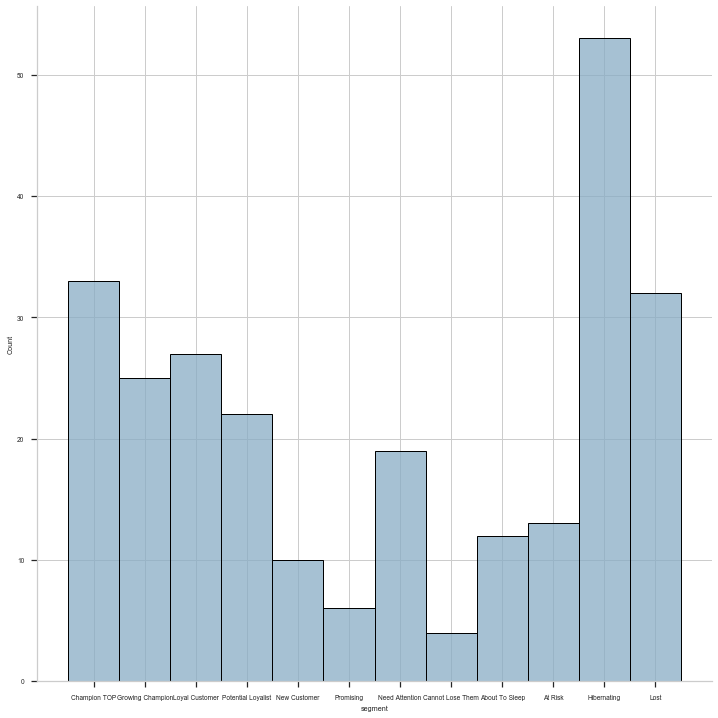

In [15]:
rfm['segment'] = pd.Categorical(rfm['segment'], categories=segment_dictionary.keys())

plt.figure(figsize=(200,200))
sns.set_context("notebook", font_scale=0.6)
sns.set_palette('twilight')
sns.displot(rfm['segment'], height=10)

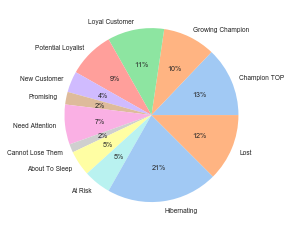

In [16]:
colors = sns.color_palette("pastel", n_colors=12)
plt.pie(rfm.groupby('segment').size(),labels=rfm.groupby('segment').size().index, colors = colors, autopct='%.0f%%')
plt.show()

In [17]:
rfm.groupby('segment').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary' : ['mean','min','max','count']
})

recency            frequency               monetary  \
                          mean  min  max       mean min  max          mean   
segment                                                                      
Champion TOP          2.454545    1    6  44.939394  12  181  29285.367273   
Growing Champion     30.640000    2   65  22.520000  11   46  12815.230800   
Loyal Customer       74.481481    1  158  14.703704   9   40   7114.058519   
Potential Loyalist   71.772727    2  162   5.954545   2   22   1619.448636   
New Customer         61.700000    1  162   1.400000   1    3    177.886000   
Promising            12.500000    1   62   2.333333   1    3    885.155000   
Need Attention       80.421053    1  161   8.842105   3   16   3888.811053   
Cannot Lose Them    236.000000  190  314   1.000000   1    1   2688.682500   
About To Sleep      151.500000   96  196   2.083333   1    5    511.409167   
At Risk             178.384615  163  206   7.230769   2   15   7511.990000   
Hibernating         188.660377   93  305   2.547170   1    7    845.059623   
Lost                257.468750  203  335   1.156250   1    2    210.854375   

                                              
                        min        max count  
segment                                       
Champion TOP        4636.53  132885.65    33  
Growing Champion    4654.28   33080.41    25  
Loyal Customer      2219.40   22999.83    27  
Potential Loyalist   166.21    3720.92    22  
New Customer         -46.43     752.61    10  
Promising            191.11    1877.09     6  
Need Attention      1299.22    6924.05    19  
Cannot Lose Them    1195.47    4526.11     4  
About To Sleep        48.05    3426.66    12  
At Risk             2950.04   21645.37    13  
Hibernating        -1845.25    4403.53    53  
Lost                -170.54     868.46    32

In [18]:
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,segment
customer,,,,,,,,
1066 POOLS LTD,191,6,1107.05,2,3,2,232,Hibernating
A D SWIMMING POOLS LTD,36,12,7780.39,4,4,4,444,Loyal Customer
A A POOLS,277,1,-170.54,1,1,1,111,Lost
A2Z POOLS,335,1,202.08,1,1,1,111,Lost
AG BUDGET SWIMMING POOLS,1,24,9787.53,5,5,5,555,Champion TOP
...,...,...,...,...,...,...,...,...
WENSUM POOLS LTD,2,27,10443.88,5,5,5,555,Champion TOP
WEST COUNTRY LEISURE POOL DEVON,93,19,11847.97,3,5,5,355,Loyal Customer
WOKINGHAM POOLS AND SPAS LTD,157,3,5526.00,3,3,4,334,Need Attention


In [19]:
rfm1 = rfm.copy()

# Data Description

In [20]:
segment_df = rfm1.groupby('segment').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})
segment_df

recency            frequency               monetary  \
                          mean  min  max       mean min  max          mean   
segment                                                                      
Champion TOP          2.454545    1    6  44.939394  12  181  29285.367273   
Growing Champion     30.640000    2   65  22.520000  11   46  12815.230800   
Loyal Customer       74.481481    1  158  14.703704   9   40   7114.058519   
Potential Loyalist   71.772727    2  162   5.954545   2   22   1619.448636   
New Customer         61.700000    1  162   1.400000   1    3    177.886000   
Promising            12.500000    1   62   2.333333   1    3    885.155000   
Need Attention       80.421053    1  161   8.842105   3   16   3888.811053   
Cannot Lose Them    236.000000  190  314   1.000000   1    1   2688.682500   
About To Sleep      151.500000   96  196   2.083333   1    5    511.409167   
At Risk             178.384615  163  206   7.230769   2   15   7511.990000   
Hibernating         188.660377   93  305   2.547170   1    7    845.059623   
Lost                257.468750  203  335   1.156250   1    2    210.854375   

                                              
                        min        max count  
segment                                       
Champion TOP        4636.53  132885.65    33  
Growing Champion    4654.28   33080.41    25  
Loyal Customer      2219.40   22999.83    27  
Potential Loyalist   166.21    3720.92    22  
New Customer         -46.43     752.61    10  
Promising            191.11    1877.09     6  
Need Attention      1299.22    6924.05    19  
Cannot Lose Them    1195.47    4526.11     4  
About To Sleep        48.05    3426.66    12  
At Risk             2950.04   21645.37    13  
Hibernating        -1845.25    4403.53    53  
Lost                -170.54     868.46    32

In [21]:
score_df = rfm1.groupby('score').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})
score_df

recency            frequency               monetary            \
             mean  min  max       mean min  max          mean       min   
score                                                                     
111    259.764706  215  335   1.000000   1    1    120.292941   -170.54   
112    245.125000  204  295   1.000000   1    1    513.457500    246.29   
113    251.333333  203  314   1.000000   1    1   2076.206667   1195.47   
121    266.000000  203  323   1.714286   1    2     84.957143      0.00   
122    245.142857  206  305   2.285714   1    3    581.647143    314.98   
...           ...  ...  ...        ...  ..  ...           ...       ...   
543      1.333333    1    2   9.000000   9    9   3149.420000   2219.40   
544      2.500000    2    3  12.666667  11   16   6445.113333   5302.03   
545      2.400000    1    6  14.200000  12   17  17457.092000  11000.55   
554      2.600000    1    6  22.600000  20   25   6830.964000   4636.53   
555      2.434783    1    6  56.478261  22  181  36738.123478   8777.19   

                        
             max count  
score                   
111       246.19    17  
112       868.46     8  
113      2713.60     3  
121       163.64     7  
122       885.77     7  
...          ...   ...  
543      4175.58     3  
544      8426.97     6  
545     20719.14     5  
554      7808.43     5  
555    132885.65    23  

[63 rows x 10 columns]

In [22]:
if world == True:
    rfm1.to_excel(f"./{month}/{country}/RFMSegments-{country}-{month}.xlsx")
    segment_df.to_excel(f"./{month}/{country}/segment-explanation-{country}-{month}.xlsx")
    score_df.to_excel(f"./{month}/{country}/score-explanation-{country}-{month}.xlsx")
elif world == False:   
    rfm1.to_excel(f"./{month}/{country}/RFMSegments-{country}-{month}.xlsx")
    segment_df.to_excel(f"./{month}/{country}/segment-explanation-{country}-{month}.xlsx")
    score_df.to_excel(f"./{month}/{country}/score-explanation-{country}-{month}.xlsx")

In [23]:
STOP

NameError: name 'STOP' is not defined

## Outliers


In [ ]:
rfm1 = rfm
plt.boxplot(rfm1.recency)
Q1 = rfm1.recency.quantile(0.25)
Q3 = rfm1.recency.quantile(0.75)
IQR = Q3 - Q1
rfm1 = rfm1[(rfm1.recency >= Q1 - 3*IQR) & (rfm1.recency <= Q3 + 3*IQR)]

In [ ]:
plt.boxplot(rfm1.frequency)
Q1 = rfm1.frequency.quantile(0.25)
Q3 = rfm1.frequency.quantile(0.75)
IQR = Q3 - Q1
rfm1 = rfm1[(rfm1.frequency >= Q1 - 3*IQR) & (rfm1.frequency <= Q3 + 3*IQR)]


In [ ]:
plt.boxplot(rfm1.monetary)
Q1 = rfm1.monetary.quantile(0.25)
Q3 = rfm1.monetary.quantile(0.75)
IQR = Q3 - Q1
rfm1 = rfm1[(rfm1.monetary >= (Q1 - 3*IQR)) & (rfm1.monetary <= (Q3 + 3*IQR))]

## K-Means
We will use the elbow method to determine the optimal amount of clusters. If we pick more clusters than necessary the added clusters will not be more descriptive of the data and will increase the amount of distortion. Some clusters will also be very small.

In [ ]:
scaler = StandardScaler()
x_scaled=scaler.fit(rfm2)
x_scaled=scaler.fit_transform(rfm2)

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)
visualizer.show()

In [ ]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm2)
clusters_scaled = rfm2.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)

In [ ]:
rfm2['cluster']= clusters_scaled['cluster_pred']
rfm2['segment']= rfm1['segment']

In [ ]:
rfm2 = pd.concat([rfm2,rfm[["recency", "frequency", "monetary", "cluster", "segment"]]]).reset_index().drop_duplicates(subset='customer', keep='first').set_index('customer')
rfm2[["recency_score", "frequency_score", "monetary_score", "score"]] = rfm[["recency_score", "frequency_score", "monetary_score", "score"]]

In [ ]:
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster", data=rfm2)
rfm2.groupby(['cluster']).count()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=rfm2['recency']
yline=rfm2['frequency']
zline=rfm2['monetary']

ax.scatter3D(xline, zline,yline,c=rfm2['cluster'])
ax.view_init(30, 60)